# Chapter 51. Introduction to Futures Contracts

Futures contracts are derivatives and they are fundamentally different from equities, so it is important to understand what they are and how they work. In this lecture we will detail the basic unit of a futures contract, the forward contract, specifics on the valuation of futures contracts, and some things to keep in mind when handling futures. Our goal here is to cover what makes futures tick before we get into performing any sort of statistical analysis of them.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Derivatives

선물계약은 파생상품이므로 파생상품이란 무었인지 명확히 하자. 파생상품은 기초자산의 가치에 dependent 한 가치를 갖는 financial instrument 이다. 

## Forward Contracts

선물계약은 선도계약이라 불리는 파생상품에 기초하고 있다. 이 것은 미래의 미리 지정한 시점에 인도가격 $K$ 를 지블하고 자산을 인수도 하기로 쌍방간에 정한 계약이다. 

시간에 따른 자산 가격을 $S_i$ 라 표시하고, $T$ 를 선도계약의 만기일로 표시하면, 선도계약 long position 의 **payoff** 는 :

$$ S_T - K $$

또한 선도계약 short position 의 payoff 는:

$$ K - S_T$$

여기서 $S_T$ 는 만기시 기초자산의 가격이고 $K$ 는 만기시 합의한 가격이다. 

In [2]:
# K is the delivery price agreed upon in the contract
K = 50
# Here we look at various different values that S_T can have
S_T = np.linspace(0, 100, 200)
# Calculate the long and short payoffs
long_payoff = S_T - K
short_payoff = K - S_T

This is the long side payoff:

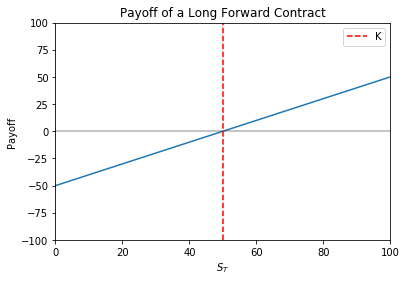

In [3]:
plt.plot(S_T, long_payoff)
plt.axhline(0, color='black', alpha=0.3)
plt.axvline(0, color='black', alpha=0.3)
plt.xlim(0, 100)
plt.ylim(-100, 100)
plt.axvline(K, linestyle='dashed', color='r', label='K')
plt.ylabel('Payoff')
plt.xlabel('$S_T$')
plt.title('Payoff of a Long Forward Contract')
plt.legend();

And this is the short side payoff:

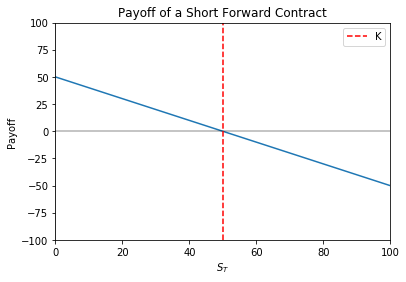

In [4]:
plt.plot(S_T, short_payoff);
plt.axhline(0, color='black', alpha=0.3)
plt.axvline(0, color='black', alpha=0.3)
plt.xlim(0, 100)
plt.ylim(-100, 100)
plt.axvline(K, linestyle='dashed', color='r', label='K')
plt.ylabel('Payoff')
plt.xlabel('$S_T$')
plt.title('Payoff of a Short Forward Contract')
plt.legend();

The S&P 500 E-Mini contract has a value based on 50 units of the value of the S&P 500 Index. This financial future has a significant advantage in liquidity compared to natural gas for the same expiry. It likely helps that the S&P 500 E-Mini cash-settled, while the natural gas contract requires arrangements to be made for transportation and storage of fuel, but the main takeaway here is that there are a lot more people trying to trade financial futures.

### Delivery and Naming
Different futures contracts will differ on the available delivery months. Some contracts have delivery every month, while some only have delivery a few times a year. The naming conventions for a given futures contract include the delivery month and year for the specific contract that they refer to. The month codes are standardized and [well-documented](http://www.investopedia.com/terms/d/deliverymonth.asp), but the specific symbol that refers to the underlying varies depending on the broker. For an overview of the contract names that we use on Quantopian, please refer to the [Futures API Introduction](https://www.quantopian.com/posts/futures-data-now-available-in-research).

The delivery terms of a futures contract are listed in the contract specifications for that underlying asset. With commodity futures, this often includes terms for the physical delivery of, for example, 1000 barrels of oil. This will vary between assets. Some contracts, particularly financials, allow for cash settlement, making it easier to deliver.

## Closing a Futures Position
In order to close a futures position, you simply take up an opposite position in the same contract. The broker will see that you have two opposite positions in the same asset so you are flat, effectively closing the account's exposure. As this requires actually being able to open the opposing position, care needs to be taken to do this in a timely manner as futures have varying liquidity as they approach expiry. The majority of volume for a given contract tends to take place during this same period of time, but there is a chance that liquidity may drop and you will be unable to close your futures positions, resulting in you taking delivery.

The delivery date calendar varies from underlying to underlying and from month to month, which means that you have to take proper care to make sure you unwind your positions in a timely manner.

Here we plot the volume of futures contracts on "Light Sweet Crude Oil" with January, February, and March delivery.

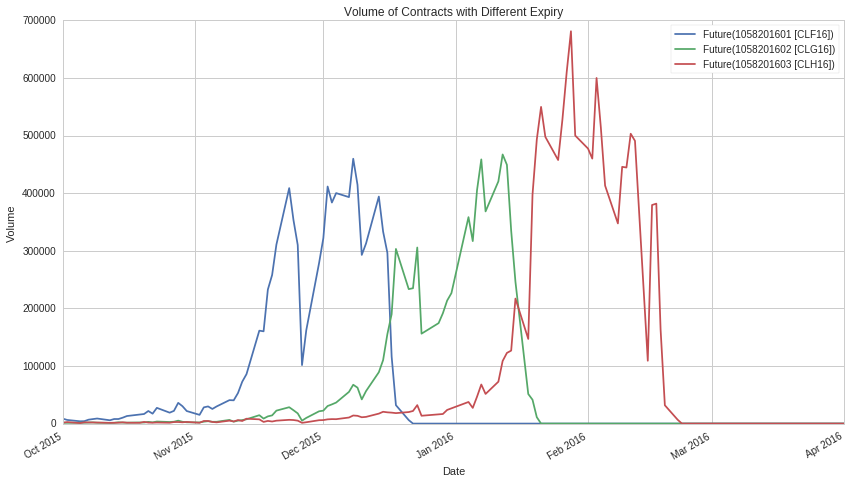

In [11]:
cls = symbols(['CLF16', 'CLG16', 'CLH16'])
contract_volume = get_pricing(cls, start_date='2015-10-01', end_date='2016-04-01', fields='volume')
contract_volume.plot()
plt.title('Volume of Contracts with Different Expiry')
plt.xlabel('Date')
plt.ylabel('Volume');

As one contract fades out of the spotlight, the contract for the next month fades in. It is common practice to **roll over** positions in contracts, closing the previous month's positions and opening up equivalent positions in the next set of contracts. Note that when you create a futures object, you can access the `expiration_date` attribute to see when the contract will stop trading.

In [12]:
cl_january_contract = symbols('CLF16')
print cl_january_contract.expiration_date

2015-12-21 00:00:00+00:00


The expiration date for this crude oil contract is in December, but the delivery does not occur until January. This time lag between expiration and delivery varies for different underlyings. For example, the S&P 500 E-Mini contract, a financial future, has an expiration date in the same month as its delivery.

In [13]:
es_march_contract = symbols('ESH17')
print es_march_contract.expiration_date

2017-03-17 00:00:00+00:00


## Spot Prices and Futures Prices
An important feature of futures markets is that as a contract approaches its expiry, its futures price will converge to the spot price. To show this, we will examine how SPY and a S&P 500 E-Mini contract move against each other. SPY tracks the S&P 500 Index, which is the underlying for the S&P 500 E-Mini contract. If we plot ten times the price of the ETF (the value is scaled down from the actual index), then ideally the difference between them should go to 0 as we approach the expiry of the contract.

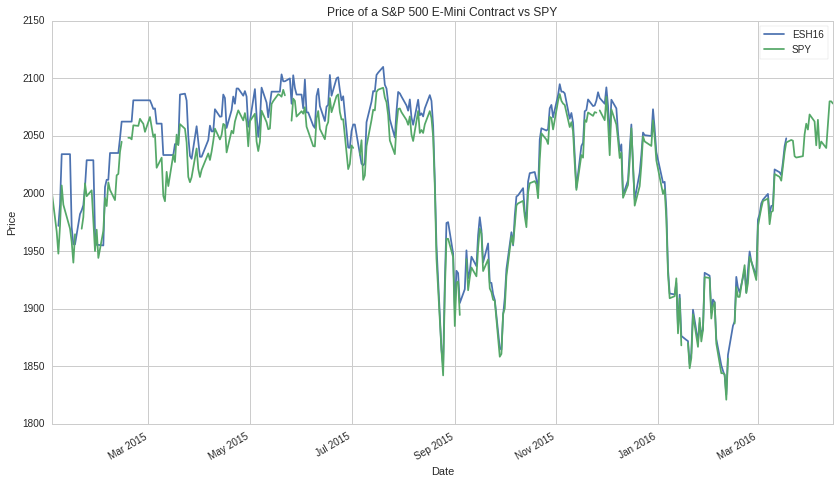

In [14]:
assets = ['SPY', 'ESH16']
prices = get_pricing(assets, start_date = '2015-01-01', end_date = '2016-04-15', fields = 'price')
prices.columns = map(lambda x: x.symbol, prices.columns)
prices['ESH16'].plot()
(10*prices['SPY']).plot()
plt.legend()
plt.title('Price of a S&P 500 E-Mini Contract vs SPY')
plt.xlabel('Date')
plt.ylabel('Price');

Looking at a plot of the prices does not tell us very much, unfortunately. It looks like the values might be getting closer, but we cannot quite tell. Let's look instead at the mean squared error between the ETF and futures prices.

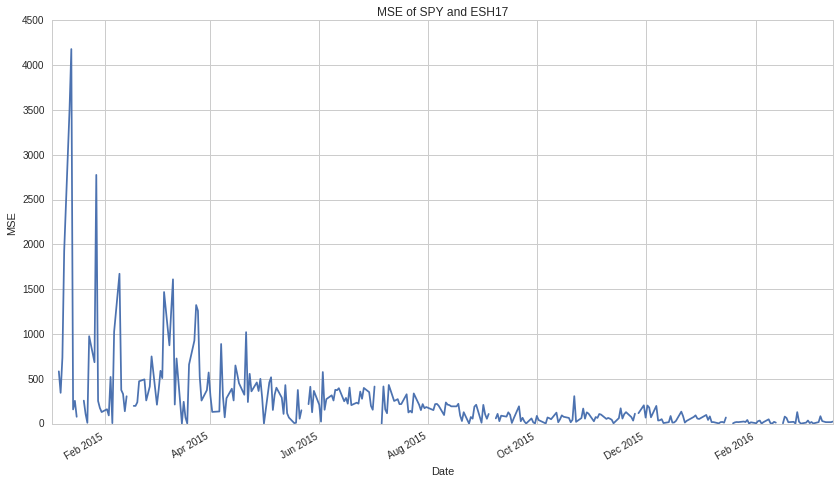

In [15]:
X = (10*prices['SPY'][:'2016-03-15'] - prices['ESH16'][:'2016-03-15'])**2
X.plot()
plt.title('MSE of SPY and ESH17')
plt.xlabel('Date')
plt.ylabel('MSE');

This indeed seems to corroborate the point that futures prices approach the spot at expiry. And this makes sense. If we are close to expiry, there should be little difference between the price of acquiring a commodity or asset now and the price at the expiry date.

### Connection Between Spot and Futures Prices
There are several ways to theoretically model futures prices, just as there are many models to model equity prices. A very basic model of futures prices and spot prices  connects them through a parameter called the **cost of carry**. The cost of carry acts as a discount factor for futures prices, such that

$$ F(t, T) = S(t)\times (1 + c)^{T - t} $$

where $F(t, T)$ is the futures price at time $t$ for maturity $T$, $S(t)$ is the spot price at time $t$, and $c$ is the cost of carry (here assumed to be constant). With continuous compounding, this relationship becomes:

$$ F(t, T) = S(t)e^{c(T - t)} $$

This is a naive representation of the relationship in that it relies on a constant rate as well as a few other factors. Depending on the underlying asset, the cost of carry may be composed of several different things. For example, for a physical commodity, it may incorporate storage costs and the convenience yield for immediate access through the spot market, while for some financial commodities it may only encompass the risk free rate.

The cost of carry on futures can be thought of similarly to dividends on stocks. When considering futures prices of a single underlying through several different maturities, adjustments must be made to account for the cost of carry when switching to a new maturity.

The further out we are from expiry, the more the cost of carry impacts the price. Here is a plot of the prices of contracts on light sweet crude for January, February, March, and April 2017 delivery. The further out the contract is from expiry, the higher the price.

In [16]:
contracts = symbols(['CLF17', 'CLG17', 'CLH17', 'CLJ17'])
prices = get_pricing(contracts, start_date='2016-11-01', end_date='2016-12-15', fields='price')
prices.columns = map(lambda x: x.symbol, prices.columns)

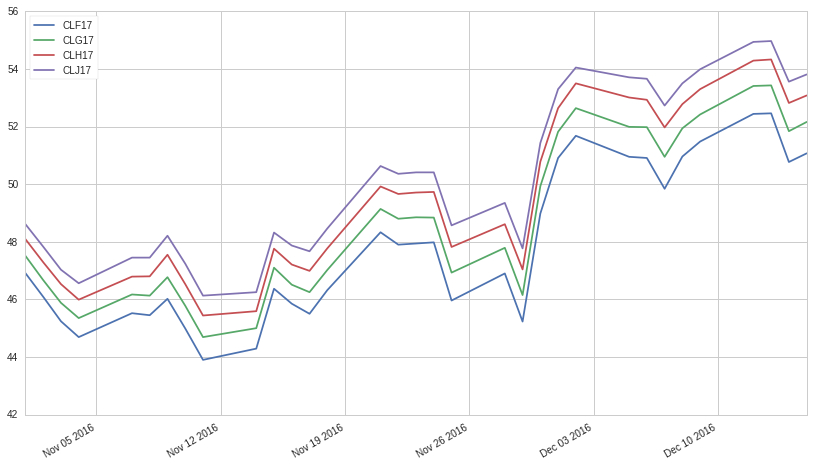

In [17]:
prices.plot();

## Contango and Backwardation
Often in futures markets we expect the futures price to be above the spot price. In this case, we can infer that participants in the market are willing to pay a premium for avoiding storage costs and the like. We call the difference between the futures price and the spot price the basis. A higher futures price than spot price indicates a positive basis, a situation which we call contango. With our cost of carry model, a positive cost of carry indicates contango.

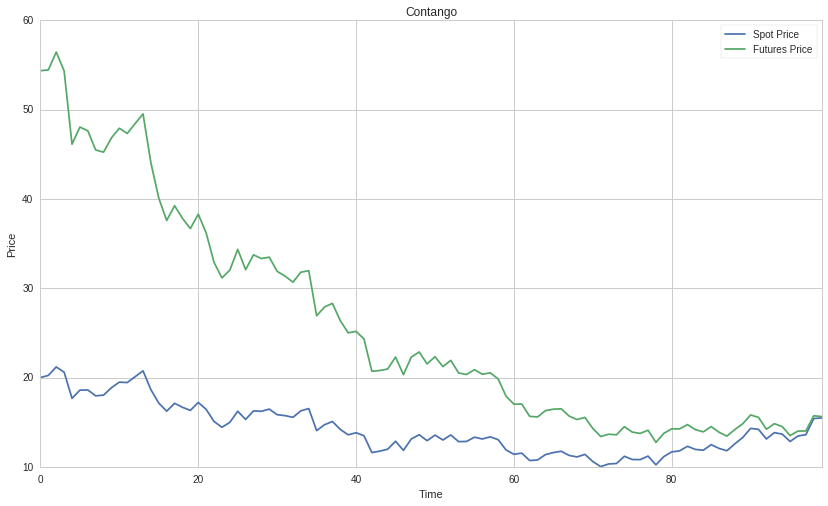

In [18]:
# A toy example to show Contango
N = 100 # Days to expiry of futures contract
cost_of_carry = 0.01
spot_price = pd.Series(np.ones(N), name = "Spot Price")
futures_price = pd.Series(np.ones(N), name = "Futures Price")
spot_price[0] = 20
futures_price[0] = spot_price[0]*np.exp(cost_of_carry*N)
for n in range(1, N): 
    spot_price[n] = spot_price[n-1]*(1 + np.random.normal(0, 0.05))
    futures_price[n] = spot_price[n]*np.exp(cost_of_carry*(N - n))

spot_price.plot()
futures_price.plot()
plt.legend()
plt.title('Contango')
plt.xlabel('Time')
plt.ylabel('Price');

Backwardation occurs when the spot price is above the futures price and we have a negative basis. What this means is that it is cheaper to buy something right now than it would be to lock down for the future. This equates to a negative cost of carry.

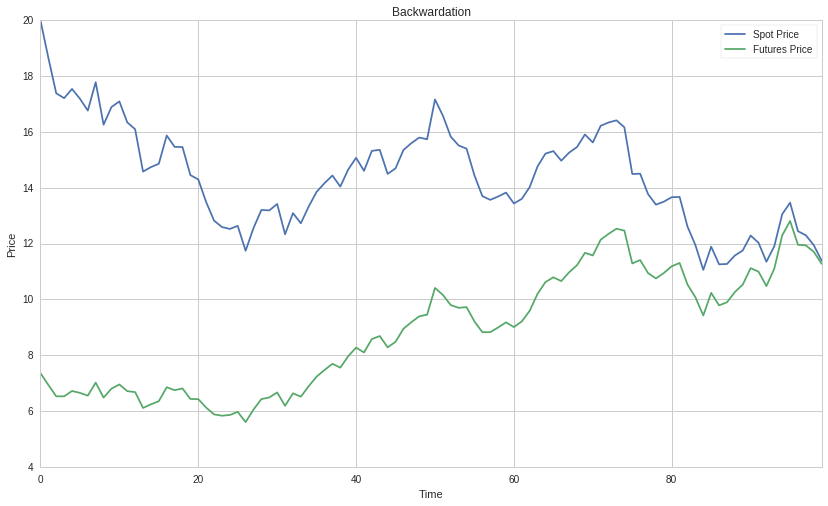

In [19]:
# A toy example to show Backwardation
N = 100 # Days to expiry of futures contract
cost_of_carry = -0.01
spot_price = pd.Series(np.ones(N), name = "Spot Price")
futures_price = pd.Series(np.ones(N), name = "Futures Price")
spot_price[0] = 20
futures_price[0] = spot_price[0]*np.exp(cost_of_carry*N)
for n in range(1, N):
    spot_price[n] = spot_price[n-1]*(1 + np.random.normal(0, 0.05))
    futures_price[n] = spot_price[n]*np.exp(cost_of_carry*(N - n))

spot_price.plot()
futures_price.plot()
plt.legend()
plt.title('Backwardation')
plt.xlabel('Time')
plt.ylabel('Price');

There are valid cases for both of these situations existing naturally. For example, backwardation is common in underlyings that are perishable or have seasonal behavior. Both allow for situations to find profit. Many futures pass in and out of both regimes before expiry. 

## Further Reading
Futures are dynamic assets with many moving components to model. This lecture has been an introduction to the core concepts within futures contracts themselves, but has avoided the specifics of designing trading algorithms on futures. We will cover these considerations in more depth as we develop more lectures on this asset.

For further reading on futures, see:

* https://www.quantopian.com/posts/futures-data-now-available-in-research
* https://en.wikipedia.org/wiki/Futures_contract
* http://www.investopedia.com/terms/f/futurescontract.asp

## References
* "Options, Futures, and Other Derivatives", by John Hull

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company. In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*